# Recommendation System for LastFM Dataset

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from fuzzywuzzy import fuzz, process
from sklearn.neighbors import NearestNeighbors
from functools import reduce
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy
from surprise import Reader
from scipy.sparse import csr_matrix 
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms import SVD
from surprise.model_selection import GridSearchCV
pd.set_option("display.max_rows", None, "display.max_columns", None)

/Users/billylopez/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Importing datasets

In [2]:
artist = pd.read_csv('Artist_lastfm.csv')
artist_tag = pd.read_csv('user_artist_tag_date_lastfm.csv')
user_tag = pd.read_csv('user_artist_tag_lastfm.csv')
plays = pd.read_csv('user_artist_weight_lastfm.csv')
user_friend = pd.read_csv('user_friend_lastfm.csv')
tags = pd.read_csv('tags_lastfm.csv',encoding='latin-1')

### Exploring Data

In [3]:
artist_tag.year.value_counts()

2010    54998
2009    43366
2008    40273
2007    20415
2011    15125
2006     9814
2005     2483
1956        3
1979        1
1957        1
Name: year, dtype: int64

In [4]:
# ua_weight_df dataframe holds the amount of plays a user played an artist
plays.head(3)

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351


In [5]:
artist.head(3)

,artistID,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...


In [6]:
# merging artist and playCount dataframe
artistPlays = pd.merge(artist, plays, on ='artistID')
artistPlays = (artistPlays.drop(columns=['url','pictureURL']).
                 rename(columns={"weight":"playCounts"}).
                 sort_values(by='playCounts', ascending=False))
artistPlays.head()

,artistID,name,userID,playCounts
2800,72,Depeche Mode,1642,352698
35843,792,Thalía,2071,324663
27302,511,U2,1094,320725
8152,203,Blur,1905,257978
26670,498,Paramore,1664,227829


In [7]:
# created artist and user rank to see which user listen to the most artist and which artist is the most played
artist_rank = (artistPlays.groupby(['name']).agg({'userID':'count','playCounts':'sum'}).
               rename(columns={"userID":'totalUniqueUsers',"playCounts":"totalArtistPlays"}).
               sort_values(['totalArtistPlays'],ascending=False))
artist_rank['avgUserPlays'] = artist_rank['totalArtistPlays']/artist_rank['totalUniqueUsers']

user_rank = (artistPlays.groupby(['userID']).agg({'name':'count','playCounts':'sum'}).
             rename(columns={"name":'totalUniqueArtists',"playCounts":"totalUserPlays"}).
             sort_values(['totalUserPlays'],ascending=False))

In [8]:
artist_rank.head(10)

,totalUniqueUsers,totalArtistPlays,avgUserPlays
name,,,
Britney Spears,522,2393140,4584.559387
Depeche Mode,282,1301308,4614.567376
Lady Gaga,611,1291387,2113.563011
Christina Aguilera,407,1058405,2600.503686
Paramore,399,963449,2414.659148
Madonna,429,921198,2147.314685
Rihanna,484,905423,1870.708678
Shakira,319,688529,2158.398119
The Beatles,480,662116,1379.408333


In [9]:
user_rank.head()

,totalUniqueArtists,totalUserPlays
userID,,
757,50,480039
2000,50,468409
1418,50,416349
1642,50,388251
1094,50,379125


In [10]:
# didn't have to join but joined both dataframes to artist_plays df to get a better look of what I'm working with
df2 = artistPlays.join(artist_rank,on='name',how='inner')
df3 = df2.join(user_rank,on='userID',how='inner').sort_values(['playCounts'],ascending=False)

In [11]:
df3.head(3)

,artistID,name,userID,playCounts,totalUniqueUsers,totalArtistPlays,avgUserPlays,totalUniqueArtists,totalUserPlays
2800,72,Depeche Mode,1642,352698,282,1301308,4614.567376,50,388251
35843,792,Thalía,2071,324663,26,350035,13462.884615,50,338400
27302,511,U2,1094,320725,185,493024,2664.994595,50,379125


### Data Visualization

/Users/billylopez/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


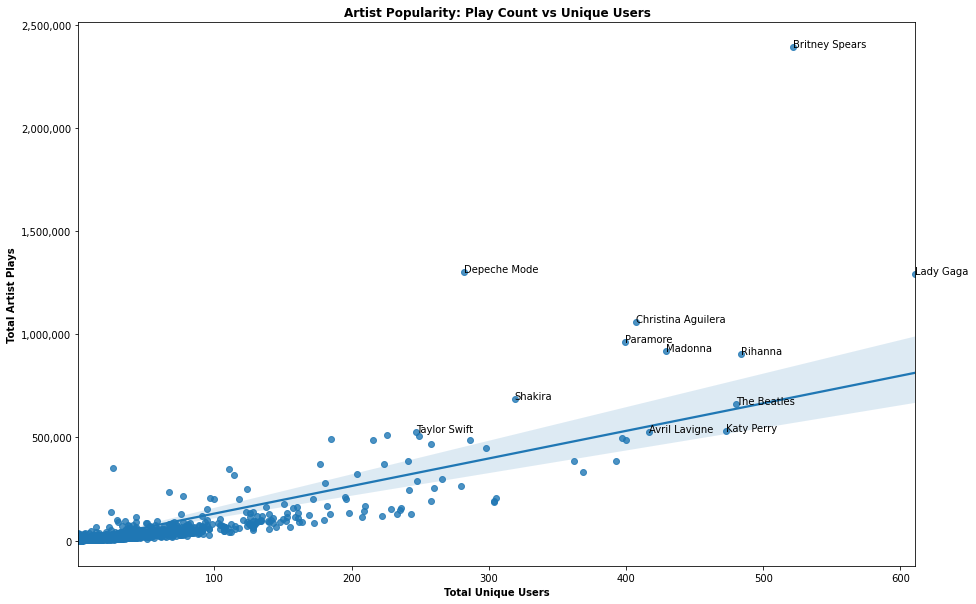

In [42]:
top_artists = artist_rank.sort_values(['totalArtistPlays'],ascending=False).index[:12]

x = artist_rank.totalUniqueUsers
y = artist_rank.totalArtistPlays
labels = artist_rank.index

fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(x,y)
ax.set_title('Artist Popularity: Play Count vs Unique Users',fontweight='bold')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:,.0f}'.format(y)))
ax.set_xlabel('Total Unique Users',fontweight='bold')
ax.set_ylabel('Total Artist Plays',fontweight='bold')

for i, t in enumerate(labels):
    if t in top_artists:
        ax.annotate(t,(x[i],y[i]))

<AxesSubplot:title={'center':'User Ranking: Total User Plays vs Unique Artist'}, xlabel='Total Unique Artists', ylabel='Total User Plays'>

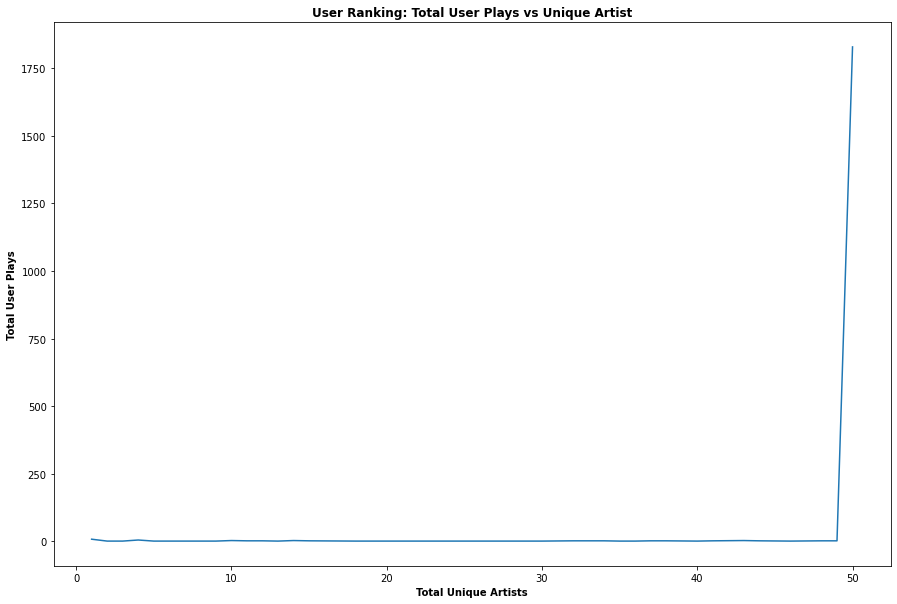

In [13]:
x=user_rank.groupby('totalUniqueArtists')['totalUserPlays'].count().index
y=user_rank.groupby('totalUniqueArtists')['totalUserPlays'].count()
# Plot the responses for different events and regions
fig, ax2 = plt.subplots(figsize=(15,10))
ax2.set_title('User Ranking: Total User Plays vs Unique Artist',fontweight='bold')
ax2.set_xlabel('Total Unique Artists',fontweight='bold')
ax2.set_ylabel('Total User Plays',fontweight='bold')

sns.lineplot(x=x,y=y)

### Train Test Split with Surprise

In [24]:
reader = Reader(rating_scale=(1, 5))
userRatings_data=Dataset.load_from_df(df3[['artistID','userID','playCounts']],reader)

In [25]:
trainset, testset = train_test_split(userRatings_data, test_size=0.3)

In [26]:
print('Type trainset :',type(trainset),'\n')
print('Type testset :',type(testset))

Type trainset : <class 'surprise.trainset.Trainset'> 

Type testset : <class 'list'>


### SVD Model with Surprise

In [27]:
# started mdeling with SVD to test the dataset
svd = SVD(n_factors=100, n_epochs=50, lr_all=0.007, reg_all=0.5)
svd.fit(trainset)
predictions = svd.test(testset)
print(accuracy.rmse(predictions))

RMSE: 3398.2087
3398.208652615796


### GridSearch for best Params

In [29]:
# running a grid search to find the best params to fit the svd model
param_grid = {
    'n_factors':[5, 10,20, 25],
    'n_epochs': [5, 10, 20], 
    'lr_all': [0.002, 0.005, 0.006],
    'reg_all': [0.4, 0.6, .8]}

In [30]:
gs_model = GridSearchCV(algo_class = SVD,param_grid = param_grid,n_jobs = -1,joblib_verbose = 5)

In [42]:
gs_model.fit(userRatings_data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 22.6min finished


In [32]:
gs_model.best_params

### Refitting SVD model with best Params

In [28]:
svd = SVD(n_factors= 5, n_epochs= 10, lr_all=0.002, reg_all= 0.6)
svd.fit(trainset)
predictions = svd.test(testset)
print(accuracy.rmse(predictions))

RMSE: 3398.2087
3398.2086525312684


### KNN Models with Surprise

####  Similarity Matrices with different metrics

In [19]:
sim_pearson = {'name':'pearson_baseline', 'user_based':False}
basic_pearson = knns.KNNBasic(sim_options=sim_pearson)
basic_pearson.fit(trainset)
predictions = basic_pearson.test(testset)
print(accuracy.rmse(predictions))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 3925.0844
3925.0843959661725


In [20]:
sim_cos = {'name':'cosine','user_based': True}
knn_means = knns.KNNWithMeans(sim_options=sim_cos)
knn_means.fit(trainset)
predictions = knn_means.test(testset)
print(accuracy.rmse(predictions))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 3925.1278
3925.127831122605


In [21]:
cv_knn_means = cross_validate(knn_means,userRatings_data)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [22]:
for i in cv_knn_means.items():
    print(i)

np.mean(cv_knn_means['test_rmse'])

('test_rmse', array([3075.49506941, 3749.73551754, 4126.80767608, 4590.45426469,
       3388.30299737]))
('test_mae', array([731.18208084, 744.40504464, 746.53410658, 749.183378  ,
       734.41724115]))
('fit_time', (34.86445426940918, 33.262694120407104, 34.82403087615967, 37.90734004974365, 38.47799491882324))
('test_time', (1.894054889678955, 2.999555826187134, 2.5242459774017334, 3.036531925201416, 1.8274421691894531))


3786.159105017609

### Item Similarity with scitkit learn with Nearest Nieghbors

In [14]:
def data_to_sparse(data,index,columns,values):
    pivot = data.pivot(index=index,columns=columns,values=values).fillna(0)
    sparse = csr_matrix(pivot.values)
    print(sparse.shape)
    return pivot,sparse

#user K Nearest Neighbors to determine cosine distance amongst artists
#tried euclidean but it over shot the distance by too much
def fit_knn(sparse):
    knn = NearestNeighbors(metric='cosine')
    knn.fit(sparse)
    print(knn)
    return knn 

In [15]:
seed = np.random.RandomState(seed=42)
def id_recommend(data,_id,model,k):
    distances, indices = (model.kneighbors(data.
                                     iloc[_id,:].
                                     values.reshape(1,-1),
                                     n_neighbors=k+1))

    for i in range(0,len(distances.flatten())):
        if i == 0:
            print(('Recommendations for {}:\n'.
                  format(data.index[_id])))
        else:
            print(('{}: {} ({:.3f})'.
                  format(i,
                         data.index[indices.flatten()[i]],
                         distances.flatten()[i])))
    return ''

In [16]:
pivot_df3,sparse_df3 = data_to_sparse(df3,index='name',columns='userID',values='playCounts')

(17632, 1892)


In [17]:
knn = fit_knn(sparse_df3)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)


In [18]:
query_index = seed.choice(pivot_df3.shape[0])
id_recommend(pivot_df3,query_index,knn,5)

Recommendations for VINILOVERSUS:

1: VINILOVERSUS (0.000)
2: Taking Back Sunday (0.792)
3: Ana Johnsson (0.856)
4: Lacuna Coil (0.864)
5: Breaking Benjamin (0.867)


''

In [39]:
query_index = pivot_df3.index.get_loc('Shakira')
id_recommend(pivot_df3,query_index,knn,10)

Recommendations for Shakira:

1: Xtuna (0.314)
2: Karl Wolf (0.326)
3: Sunidhi Chauhan (0.326)
4: Cameron Cartio (0.326)
5: K.K. (0.326)
6: Outlandish (0.326)
7: Shreya Ghoshal & Shaan (0.326)
8: Enrique Iglesias (0.410)
9: Black Eyed Peas (0.474)
10: Beyoncé (0.491)


''

In [20]:
def fuzzy_match(query_subject,data):
    ratio_tuples = []
    
    # each artist name is the subject in the data index
    # each artist in the data is compared against our query subject to determine percentage match
    # NOTE there may be ways to optimize this process by not looping through all artists
    for subject in data.index:
        ratio = fuzz.ratio(subject.lower(),query_subject.lower())
        current_query_idx = data.index.tolist().index(subject)
        ratio_tuples.append((subject, ratio,current_query_idx))
        
    # our findings are then sorted based on match rating, and top two are kept
    ratio_tuples = sorted(ratio_tuples, key=lambda tup: tup[1],reverse=True)[:2]
    
    print('Top matches: {}\n'.format([(x[0],x[1]) for x in ratio_tuples]))  
    
    match = ratio_tuples[0][0]
    
    return match, ratio_tuples

def artist_recommend(query_artist, data, model,k):
    
    # determining artist matches using fuzzy matching
    
    match, ratio_tuples = fuzzy_match(query_artist,data)
    
    # look up artist by query index
    id_recommend(data, ratio_tuples[0][2],model,k)   
    return ''

In [38]:
artist_recommend('Shakira',pivot_df3,knn,10)

Top matches: [('Shakira', 100), ('Sakura', 77)]

Recommendations for Shakira:

1: Xtuna (0.314)
2: Karl Wolf (0.326)
3: Sunidhi Chauhan (0.326)
4: Cameron Cartio (0.326)
5: K.K. (0.326)
6: Outlandish (0.326)
7: Shreya Ghoshal & Shaan (0.326)
8: Enrique Iglesias (0.410)
9: Black Eyed Peas (0.474)
10: Beyoncé (0.491)


''

In [34]:
# Data has artist that get only 1 or 2 listens so going to try and clean data by giving feature minimums
minPlaysPerUser = 1000 # minimum aggregate play count per user
minUniqueArtistPlays = 10 # minimum different artists that need values per user to be counted
minArtistPlays = 10000 # minimum times an artist must be played
minListeners = 10 # minimum unique listeners of artist to be played

def threshold(data,
                    minPlaysPerUser,
                    minUniqueArtistPlays,
                    minArtistPlays,
                    minListeners):
    
    filtered = (data[(data['totalUserPlays']>=minPlaysPerUser) & 
               (data['totalUniqueArtists']>=minUniqueArtistPlays) & 
               (data['totalArtistPlays']>=minArtistPlays) & 
               (data['totalUniqueUsers']>=minListeners)])

    # confirm our min thresholds have been applied
    print('MINIMUM VALUES')
    print('totalUserPlays from {} to {}'.format(min(data.totalUserPlays),min(filtered.totalUserPlays)))
    print('totalUniqueArtists from {} to {}'.format(min(data.totalUniqueArtists),min(filtered.totalUniqueArtists)))
    print('totalArtistPlays from {} to {}'.format(min(data.totalArtistPlays),min(filtered.totalArtistPlays)))
    print('totalUniqueUsers from {} to {}'.format(min(data.totalUniqueUsers),min(filtered.totalUniqueUsers)))

    print('\nFILTER IMPACT')
    print("FILTERED Users: {} Artists: {}".format(len(filtered['userID'].unique()),
                                                           len(filtered['name'].unique())))
    print("ORIGINAL Users: {} Artists: {}".format(len(data['userID'].unique()),
                                                           len(data['name'].unique())))
    print("FILTERED % ORIGINAL Users: {:.1f}% Artists: {:.1f}%".format(100*(len(filtered['userID'].unique())/len(data['userID'].unique())),
                                                           100*(len(filtered['name'].unique())/len(data['name'].unique()))))
    return filtered

df4 = threshold(df3,minPlaysPerUser,minUniqueArtistPlays,minArtistPlays,minListeners)

MINIMUM VALUES
totalUserPlays from 3 to 1001
totalUniqueArtists from 1 to 10
totalArtistPlays from 1 to 10007
totalUniqueUsers from 1 to 10

FILTER IMPACT
FILTERED Users: 1790 Artists: 871
ORIGINAL Users: 1892 Artists: 17632
FILTERED % ORIGINAL Users: 94.6% Artists: 4.9%


In [35]:
pivot_df4,sparse_df4 = data_to_sparse(df4,index='name',columns='userID',values='playCounts')
knn = fit_knn(sparse_df4)

(871, 1790)
NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)


In [45]:
artist_recommend('Shakira',pivot_df4,knn,10)

Top matches: [('Shakira', 100), ('Air', 60)]

Recommendations for Shakira:

1: Enrique Iglesias (0.410)
2: Black Eyed Peas (0.474)
3: Beyoncé (0.491)
4: Ke$ha (0.562)
5: Bruno Mars (0.638)
6: Michael Jackson (0.675)
7: Katy Perry (0.733)
8: Eminem (0.740)
9: Rihanna (0.777)
10: Gwen Stefani (0.811)


''